# Getting Started - Creating Categorical Image Predictor Models
> My First three FastAI models in under 20 mins.

- toc: true
- branch: master
- badges: true
- comments: true
- author: Kashish Mukheja
- categories: [fastpages, jupyter]

# Overview of this blog
This blog post contains a simple fast AI model that I created by following the lesson 1 of the latest Fast AI course. I have used a different dataset (person's emotion dataset fetched using duckduckgo) here and have almost replicated the steps used by Jeremy to train and predict an image classifier model. I'm new to Deep Learning, as well as blogging. Hence, 

**Note** :
1. This Blog post is written with an intention of learning how to use Jupyter Notebooks with fastpages to create blog posts.
2. This is not a very verbose tutorial, as my aim was to just get a hands on into the FastAi's code, and create a simple blog post out of it.
3. Future blogs that I'll write will focus more on the actual definitions of concepts/techniques and code by code walkthrough of the notebook that I'll create as I'll follow the course along.
4. I have added "Appendix" section at the bottom of the blog, to provide some useful (and can be basic) commands that I have learned as part of the notebook.

# Step 1 : Installing fast's latest version

In [1]:
#collapse-output
pip install -Uqq fastbook

Note: you may need to restart the kernel to use updated packages.


In [1]:
# hide
from fastbook import *
from fastai import *

# Step 2 : Defining an Image Search Function
**Function Signature** : search_images(term, max_images)

**Input** :
- *term* - The search term to be provided into the search engine
- *max_images* - Number of images for which URLs to be generated

**Output** : URLs of the images searched in the duckduckgo search engine

In [2]:
#collapse-show
from fastcore.all import *
import time

def search_images(term, max_images=200):
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        data = urljson(requestUrl,data=params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

In [3]:
# hide
urls = search_images('sad human', max_images=1)
urls[0]

'https://image.freepik.com/free-photo/sad-emotional-boy-human-emotions-facial-expression-concept-upset-cute-boy_167187-400.jpg'

# Step 3 : Downloading & Viewing a Searched image
1. We'll be importing `download_url` from `fastdownload` to download the list of URLs in a destination path provided as function argument
2. We'll then import fastai's vision, and open an Image with a thumbnail of 256*256

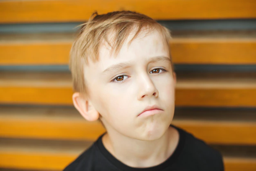

In [4]:
from fastdownload import download_url
dest = 'human_sad.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

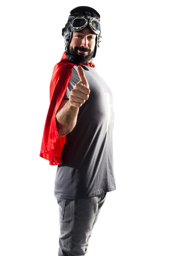

In [5]:
download_url(search_images('happy human photos', max_images=1)[0], 'human_happy.jpg', show_progress=False)
Image.open('human_happy.jpg').to_thumb(256,256)

# Cleaning the directories

We will now remove any existing content that is present in the directories which we'll use for downloading and saving the images.
Note: This will only work if you already have a directory with the below path. If not, then it will produce an error.

In [6]:
import shutil
downloaded_path = Path('happy_sad_angry_downloaded')
resized_path = Path("happy_sad_angry_resized")
shutil.rmtree(downloaded_path)
shutil.rmtree(resized_path)

# Step 4 - Organising the data
1. Download the different categories of images in *happy_sad_angry_downloaded* directory
2. Resizing all the images downloaded and saving the resized images in *happy_sad_angry_resized* directory
3. Some photos might not download correctly which could cause our model training to fail, hence remove them:

In [7]:
#collapse-output
searches = 'happy human','sad human','angry human'
downloaded_path = Path('happy_sad_angry_downloaded')
resized_path = Path("happy_sad_angry_resized")

for o in searches:
    dest_downloaded = (downloaded_path/o)
    dest_downloaded.mkdir(exist_ok=True, parents=True)
    download_images(dest_downloaded, urls=search_images(f'{o} photo'))
    resize_images(downloaded_path/o, max_size=400, dest=resized_path/o)

/root/mambaforge/lib/python3.9/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [8]:
failed = verify_images(get_image_files(resized_path))
failed.map(Path.unlink)
len(failed)

0

# Step 5 - Creating the DataBlock

To train a model, we'll need DataLoaders, which is an object that contains a :
1. Training set (the images used to create a model) and a ;
2. Validation set (the images used to check the accuracy of a model -- not used during training). 
In fastai we can create that easily using a DataBlock, and view sample images from it:

## DataBlock API
1. The inputs are going to be images “ImageBlock” and the outputs are going to be categories “CategoryBlock”.
2. `get_image_files` is used to get the items we require
3. We define a splitter to split the dataset into Training & Validation Set. In this case, we are using a `RandomSplitter` with 20% data for validation
4. `get_y` takes the label for the images. Here, `parent_label` is the name of the parent (or folder) for each image, i.e., happy person, sad person, angry person
5. Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).


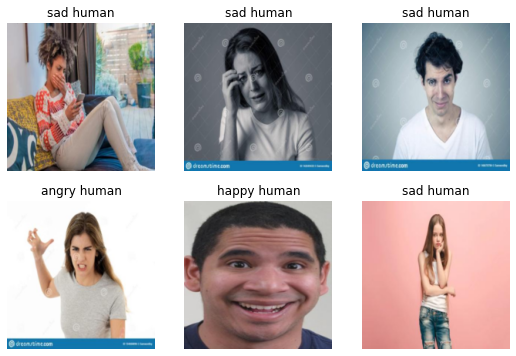

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(resized_path)

dls.show_batch(max_n=6)

# Step 6 - Creating the Vision Learner
Here is where the actual magic happens. Yes, we're not aware about the fun calculations underneath at the moment, hence, let's call it as magic :wink: 
1. We're now training the model using the dataloader that we created in the previous step.
2. We define *error_rate* as our metrics, which is nothing but the mean squared error
3. We provide `resnet18` as the architecture(pre-trained model) to train our model. This is the basis of transfer learning, which will be covered in the later blogs.

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.000713,1.274472,0.552632,00:04


epoch,train_loss,valid_loss,error_rate,time
0,1.384295,1.126901,0.473684,00:04
1,1.099846,1.033579,0.385965,00:04
2,0.864820,1.013857,0.403509,00:04


In [13]:
# hide
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

## Observations:
1. The error_rate is currently ~0.4* ( " * " signifies followed by any digits) in the model that I trained. However, in lesson 1 official notebooks, I saw that the error_rate is (0.01*) after 3 epochs. The difference between both the losses look noteworthy. I believe, that the dataset isn’t quite good (or augmented) yet for model to train ?

2. I have seen that the error_rate reduces at 2nd epoch, and then increases in the 3rd epoch. The loss should be ideally unidirectional (i.e., decreasing after each epoch), or accuracy must be increasing. What does this pattern above imply ?

I'll wait for the subsequent lectures to get the answer to the above questions!

# Step 7 - Predictions
We'll now use the model to predict the images we downloaded initially to categorize one of the three categories

In [14]:
is_happy,x,probs = learn.predict(PILImage.create('human_happy.jpg'))
print(f"This is a: {is_happy}.")
print(f"Probability the person is happy: {probs[1]:.4f}")

This is a: happy human.
Probability the person is happy: 0.8305


In [15]:
print(learn.predict(PILImage.create('human_happy.jpg')))

('happy human', TensorBase(1), TensorBase([0.0033, 0.8305, 0.1662]))


In [16]:
is_sad,_,probs = learn.predict(PILImage.create('human_sad.jpg'))
print(f"This is a: {is_happy}.")
print(f"Probability the person is sad: {probs[2]:.4f}")

This is a: happy human.
Probability the person is sad: 0.9988


In [17]:
print(learn.predict(PILImage.create('human_sad.jpg')))

('sad human', TensorBase(2), TensorBase([3.9544e-05, 1.1677e-03, 9.9879e-01]))


# Step 8 - Using a different dataset and training the model
## Cat Vs Tiger DataSet
We'll now be using a simple tiger vs cat dataset downloaded from duckduckgo, and observe the predictions. All steps from Step 2-7 will be repeated

*Displaying the Tiger Image Downloaded for prediction*

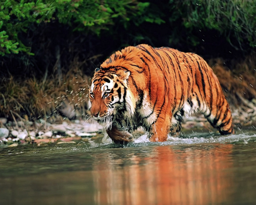

In [7]:
# collapse-hide

# Downloading a tiger image to predict
from fastdownload import download_url
urls = search_images('tiger photos', max_images=10)
dest = 'tiger.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

*Displaying the Cat Image Downloaded for prediction*

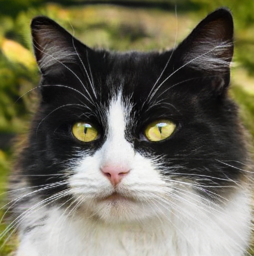

In [8]:
# collapse-hide

# Downloading a cat image to predict
download_url(search_images('cat photos', max_images=1)[0], 'cat.jpg', show_progress=False)
Image.open('cat.jpg').to_thumb(256,256)

In [10]:
# hide
import shutil
downloaded_path = Path('tiger_cat_downloaded')
resized_path = Path("tiger_cat_resized")
shutil.rmtree(downloaded_path)
shutil.rmtree(resized_path)

*Downloading all the Tiger & Cat Images in the respective parent folder and displaying 6 images*

In [11]:
# collapse-hide
searches = 'tiger','cat'
downloaded_path = Path('tiger_cat_downloaded')
resized_path = Path("tiger_cat_resized")

for o in searches:
    dest_downloaded = (downloaded_path/o)
    dest_downloaded.mkdir(exist_ok=True, parents=True)
    download_images(dest_downloaded, urls=search_images(f'{o} photo'))
    resize_images(downloaded_path/o, max_size=400, dest=resized_path/o)

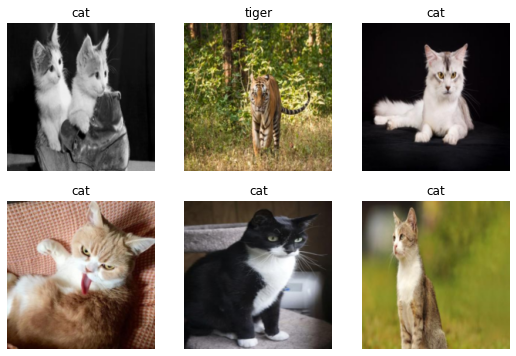

In [12]:
# collapse-hide

failed = verify_images(get_image_files(resized_path))
failed.map(Path.unlink)
len(failed)

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(resized_path)

dls.show_batch(max_n=6)

In [13]:
# Model Learning
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.878760,0.110614,0.040541,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.127793,0.020094,0.000000,00:02
1,0.071790,0.040789,0.013514,00:02
2,0.047379,0.040947,0.013514,00:02


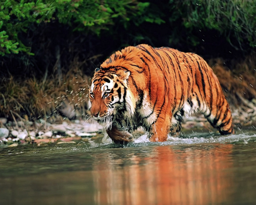

In [15]:
# collapse-hide
Image.open('tiger.jpg')
im.to_thumb(256,256)

In [16]:
# collapse-show
print(learn.predict(PILImage.create('tiger.jpg')))
is_tiger,_,probs = learn.predict(PILImage.create('tiger.jpg'))
print(f"This is a: {is_tiger}.")
print(f"Probability : {probs[1]:.4f}")

('tiger', TensorBase(1), TensorBase([5.1261e-09, 1.0000e+00]))


This is a: tiger.
Probability : 1.0000


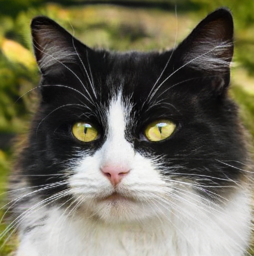

In [18]:
# collapse-hide
Image.open('cat.jpg').to_thumb(256,256)

In [20]:
# collapse-show

print(learn.predict(PILImage.create('cat.jpg')))
is_tiger,_,probs = learn.predict(PILImage.create('cat.jpg'))
print(f"This is a: {is_tiger}.")
print(f"Probability : {probs[0]:.4f}")

('cat', TensorBase(0), TensorBase([0.9984, 0.0016]))


This is a: cat.
Probability : 0.9984


## BackPack Vs Purse DataSet

We'll now be using a simple BackPack vs Purse dataset downloaded from duckduckgo, and observe the predictions. All steps from Step 2-7 will be repeated

*Displaying the BackPack Image Downloaded for prediction*

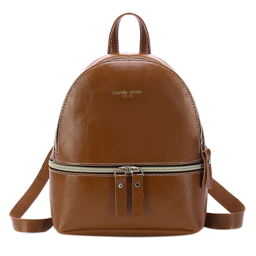

In [21]:
# collapse-hide

# Downloading a backpack image to predict
from fastdownload import download_url
urls = search_images('ladies backpack', max_images=10)
dest = 'backpack.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

*Displaying the Purse Image Downloaded for prediction*

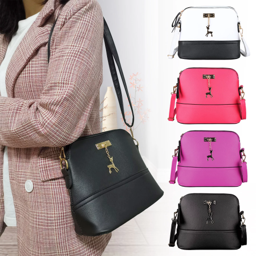

In [22]:
# collapse-hide

# Downloading a cat image to predict
download_url(search_images('ladies purse', max_images=1)[0], 'purse.jpg', show_progress=False)
Image.open('purse.jpg').to_thumb(256,256)

- As you can see, the purse image has multuple purses and a lady as well as part of the image. Since, this notebook doesn't deal with any explicit data cleaning, we'll let this data be as it is and proceed further

In [23]:
# hide
import shutil
downloaded_path = Path('backpack_purse_downloaded')
resized_path = Path("backpack_purse_resized")
shutil.rmtree(downloaded_path)
shutil.rmtree(resized_path)

*Downloading all the BackPack & Purse Images in the respective parent folder and displaying 6 images*

In [24]:
# collapse-hide
searches = 'ladies backpack','ladies purse'
downloaded_path = Path('backpack_purse_downloaded')
resized_path = Path("backpack_purse_resized")

for o in searches:
    dest_downloaded = (downloaded_path/o)
    dest_downloaded.mkdir(exist_ok=True, parents=True)
    download_images(dest_downloaded, urls=search_images(f'{o} photo'))
    resize_images(downloaded_path/o, max_size=400, dest=resized_path/o)

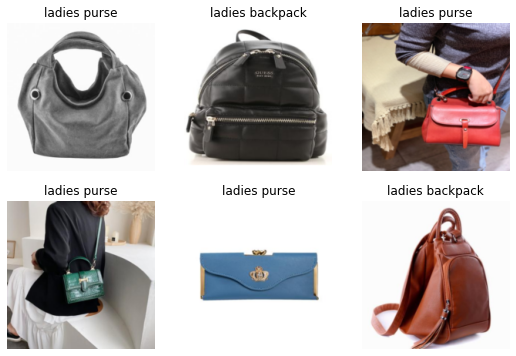

In [25]:
# collapse-hide

failed = verify_images(get_image_files(resized_path))
failed.map(Path.unlink)
len(failed)

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(resized_path)

dls.show_batch(max_n=6)

In [26]:
# Model Learning
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.093938,1.100249,0.371795,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.743325,0.566097,0.205128,00:04
1,0.570042,0.460896,0.166667,00:03
2,0.431604,0.429654,0.179487,00:02


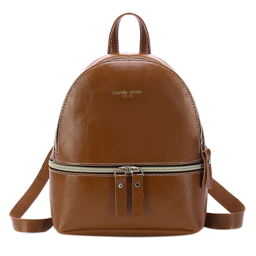

In [30]:
# collapse-hide
Image.open('backpack.jpg').to_thumb(256,256)

In [34]:
# collapse-show
print(learn.predict(PILImage.create('backpack.jpg')))
is_backpack,_,probs = learn.predict(PILImage.create('backpack.jpg'))
print(f"This is a: {is_backpack}.")
print(f"Probability : {probs[0]:.4f}")

('ladies backpack', TensorBase(0), TensorBase([9.9997e-01, 3.1113e-05]))


This is a: ladies backpack.
Probability : 1.0000


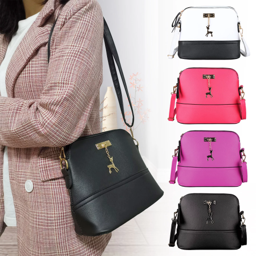

In [33]:
# collapse-hide
Image.open('purse.jpg').to_thumb(256,256)

In [36]:
# collapse-show
print(learn.predict(PILImage.create('purse.jpg')))
is_backpack,_,probs = learn.predict(PILImage.create('purse.jpg'))
print(f"This is a: {is_backpack}.")
print(f"Probability : {probs[1]:.4f}")

('ladies purse', TensorBase(1), TensorBase([0.0173, 0.9827]))


This is a: ladies purse.
Probability : 0.9827


# Observations from all models

1. Even though the underlying code remained identical for all three datasets, it is seen that the model trained had significantly different error_rates and valid_loss for different images. It can be reasoned out, why the accuracy in "Tiger Vs car" model was the highest, in comparison to "Backpack Vs Purse" or "Angry Vs Sad Vs Happy Emotion" models. The primary reason behind the anomoly is that we almost did no data cleaning in any of the images, and while the Cats/Tigers images were already pretty good for the model to train, the other images required augmentation and futher preprocessing. For E.g., there are multiple humans within a single image for a "happy person" dataset, and multiple purses along with a lady present in the "purse" images. 
2. All the models predicted correctly with almost perfect accuracy, with almost no data cleaning or feature engineering.

# End
As you can see, we have successfully trained three models and predicted results in well under 20 mins. A couple of models aren't quite good enough yet. What can be the possible reasons ? I'll wait for the subsequent lectures to find out! This was a very brief introduction blog post to the image classification model in the fastAI, with almost no tweaks in the parameters, or pre-trained models, or data augmentations. The below section is completely optional, and just provide some additional commands that are tend to be useful in general, or which I have learned as completely new while doing this project.

# Appendix

## Optional Cells

- This cell can be run if you want to delete the whole folder along with the contents. This will delete any/all directories and files that are present inside path object.


```python
import shutil
path = Path('resized_fruits')
shutil.rmtree(path)
```

- Deleting only Files in a directory

```python
flag_search = 'happy person'
path = Path('happy_sad_angry')

dest_flag_search = (path/flag_search) # Path to the "happy person" folder

files = os.listdir(dest_flag_search)
for fi in files:
    print(fi)
    os.unlink(dest_flag_search/fi)
```
    
- Deleting a Folder (Note: This will only work when the folders are empty)

```python
searches = 'happy person','sad person','angry person'
path = Path('happy_sad_angry')

for o in searches:
    os.rmdir(path/o)
```

## Challenges/Errors Faced

1. Same File error - See post : https://forums.fast.ai/t/same-file-path-error-while-resizing-images-lesson-1/97601
> Note: While running the resize_images() method, the resized images were created with the same file name and path as of downloaded images, and hence the error was producing. Although, I'm not sure, why this error didn't appear in the original notebook for lesson 1.


## Useful Commands learned

### OS Specific
1. To create a path to a folder or file :-
```python 
path = Path(happy_sad_angry/abc.jpg)
```
2. To delete a directory :- 
```python
os.rmdir(<path>)
```
3. To delete files in a folder :- 
```python
os.unlink(<filepath>)
```
4. To list directories and files in a folder
```python
os.listdir(<path>)
```
5. To install latest versions of a library
```python
!pip install -Uqq fastbook
```
6. To get the os environment
```python
os.environ()
```
You can also use `os.environ().get(<key>)` 

### FastAI Specific

1. To download using URL
```python
from fastdownload import download_url
download_url(<url>, <dest_file>, show_progress=False)
```
2. FastAI's vision imports
```python
from fastai.vision.all import *
```
3. To download and resize images to equal resolution
```python
download_images(<download_path>, urls= <list of url>)
resize_images(<downloaded_path>, max_size=400, dest=<resized_path>)
```
4. To open an image from the path
```python
PILImage.create('person_sad.jpg')
```
5. To predict provided an item : Returns label(or category), index to look from the probability tensor, probabilities for all category (as a tensor)
```python
learn.predict(<item>)
```
**Output** : ('sad person', TensorBase(2), TensorBase([3.2509e-03, 1.1917e-04, 9.9663e-01]))

### Pythonic Image

1. To open an image in lazy manner (i.e., it identifies the file, but the file remains open and the actual image data is not read from the file until you try to process the data) and set thumbnail to 256*256
```python
im = Image.open(<dest_file>)
im.to_thumb(256,256)
```

### Pythonic Strings

1. Formatted Strings
```python
o = 'happy person
f'{o} photo'
```
**Output** : happy person photo

## Further Learnings (Todo)

1. Using Regex
2. Define Datablock
3. Define Learner